# Summer School - Modeling Water Fluxes In The Soil-Plant System

## Coupled Soil and Root Hydraulics, including dynamic perirhizal models



In [26]:
import os, sys
sourcedir = os.getcwd()+"/../../../../"
sys.path.append(sourcedir); sys.path.append(sourcedir+"CPlantBox/"); sys.path.append(sourcedir+"CPlantBox/src/")
sys.path.append(sourcedir+"dumux-rosi/python/modules/");
sys.path.append(sourcedir+"dumux-rosi/python/modules/fv/");
sys.path.append(sourcedir+"dumux-rosi/build-cmake/cpp/python_binding/"); 

import plantbox as pb  # CPlantBox
from functional.PlantHydraulicParameters import PlantHydraulicParameters  
from functional.PlantHydraulicModel import HydraulicModel_Meunier
from rosi_richards import RichardsSP
from richards import RichardsWrapper  # Python part, macroscopic soil model
from functional.xylem_flux import *  # root system Python hybrid solver
from rhizo_models import *  # Helper class for cylindrical rhizosphere models

import visualisation.vtk_plot as vp
import functional.van_genuchten as vg
from functional.root_conductivities import *

import numpy as np
import timeit
import matplotlib.pyplot as plt

In [40]:
""" soil """
min_b = [-4., -4., -15.]  # cm
max_b = [4., 4., 0.]  # cm
cell_number = [7, 7, 15]  # [1]
periodic = False
loam = [0.08, 0.43, 0.04, 1.6, 50]
soil_ = loam
soil = vg.Parameters(soil_)
initial = -400  

""" root system """
path = "../../../modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI_modified" 
trans = 3.  # average per day [cm3 /day] (sinusoidal)
wilting_point = -15000  # [cm]
rs_age = 6 

""" rhizosphere models """
mode = "dumux"  # or "dumux"
NC = 10  # dof+1
logbase = 1.5  # according to Mai et al. (2019)
split_type = 1 # division of the flow between the perirhizal zones (0: volume,1: surface, 2: length)

""" simulation time """
sim_time = 0.5 # 0.65  # 0.25  # [day]
dt = 30. / (24 * 3600)  # time step [day]
NT = int(np.ceil(sim_time / dt))  # number of iterations

In [41]:
""" Initialize macroscopic soil model """
s = RichardsWrapper(RichardsSP())
s.initialize()

s.createGrid(min_b, max_b, cell_number, periodic)  # [cm]
s.setHomogeneousIC(initial, True)  # cm pressure head, equilibrium
s.setTopBC("noFlux")
s.setBotBC("noFlux")
s.setVGParameters([soil_])
s.setParameter("Newton.EnableAbsoluteResidualCriterion", "True")
s.setParameter("Soil.SourceSlope", "1000")  # turns regularisation of the source term on
s.initializeProblem()
s.setCriticalPressure(wilting_point)  # new source term regularisation
s.ddt = 1.e-5  # [day] initial Dumux time step

""" Initialize plant model """
plant = pb.MappedPlant(1)
plant.enableExtraNode()
plant.readParameters(path + name + ".xml")
for p in plant.getOrganRandomParameter(pb.root):
    p.dx = 1
    p.dxMin = 0.1
    
if not periodic:
    sdf = pb.SDF_PlantBox(0.99 * (max_b[0] - min_b[0]), 0.99 * (max_b[1] - min_b[1]), max_b[2] - min_b[2])
else:
    sdf = pb.SDF_PlantBox(np.Inf, np.Inf, max_b[2] - min_b[2])
plant.setGeometry(sdf)

""" 
Initialize plant model 
"""
rs = RhizoMappedSegments(plant, wilting_point, NC, logbase, mode)
params = PlantHydraulicParameters()  
params.read_parameters("../../../modelparameter/functional/plant_hydraulics/couvreur2012")
hm = HydraulicModel_Meunier(rs.ms, params)
hm.wilting_point = wilting_point  

""" Coupling (map indices) """
rs.ms.setRectangularGrid(pb.Vector3d(min_b[0], min_b[1], min_b[2]), pb.Vector3d(max_b[0], max_b[1], max_b[2]),
                        pb.Vector3d(cell_number[0], cell_number[1], cell_number[2]), False, False)
picker = lambda x, y, z: s.pick([x, y, z])  #  function that return the index of a given position in the soil grid
rs.ms.setSoilGrid(picker)  # maps segments, maps root segements and soil grid indices to each other in both directions

plant.initialize(True)
plant.simulate(rs_age, True)
hm.test()  # sanity checks

No parameter file found. Continuing without parameter file.
Computed bounding box tree with 1469 nodes for 735 grid entities in 0.000320399 seconds.
Computed bounding box tree with 1469 nodes for 735 grid entities in 0.000199499 seconds.
MappedPlant::initializeLB 
PlantHydraulicModel.test():
548 nodes:
Node 0 Seed::initialize: RootSystem 
Seed::initialize: Shoot borne definition is DEPRICATED, shoot borne roots will be handeled like basal roots 
Organism::simulate: from 0 to 6 days
nodes moved 0
new nodes added 546
segments added 546
Number of segments 547, including 546 new 
[ 0.1  0.  -3. ]
Node 1 [ 0.  0. -3.]
Node 2 [-1.53409340e-03  4.19112695e-04 -3.99999874e+00]
Node 3 [-0.02833665 -0.03781923 -4.37373279]
Node 4 [ 0.88225144 -0.40852078 -4.556516  ]
547 segments:
Segment 0 [0 1] subType 0
Segment 1 [1 2] subType 1
Segment 2 [2 3] subType 1
Segment 3 [3 4] subType 2
Segment 4 [4 5] subType 2
Collar segment index 0
Collar segment [0 1]
0 segments with length < 1.e-5 cm
6 differen

In [42]:

""" 
Initialize local soil models (around each root segment) 
"""
start_time = timeit.default_timer()
x = s.getSolutionHead()  # initial condition of soil [cm]
dcyl = len(rs.ms.segments)
rs.initialize(soil_, x, np.array(range(dcyl)))
print ("Initialized [{:g}-{:g}] in {:g} s".format(0, dcyl, timeit.default_timer() - start_time))



initializing look up tables
done

DuMux Solver 1D (CCTpfa method) no problem initialized on process rank 1/1

                ##                  @@@@          @   @         @ @
             ###   #                @   @         @@ @@          @ 
           ##       #               @   @  @   @  @ @ @  @   @  @ @
         ##          #              @   @  @   @  @   @  @   @     
        #             #             @@@@    @@@   @   @   @@@      
       #               #                                           
      #                 #                                          
     #                   ##        %%%                          3.8
    #                      ###    %   %  %%     %%                 
####                          #%%%     %%  %%%%%  %%%%%%%%%%%%%%%%%


DuMux Solver 1D (CCTpfa method) no problem initialized on process rank 1/1

                ##                  @@@@          @   @         @ @
             ###   #                @   @         @@ @@         

In [43]:
""" 
Simulation 

loop
1. xylem model
2. local soil models
3. macroscopic soil model 
"""
print("Starting simulation")
start_time = timeit.default_timer()

# for post processing
min_hs, min_hx, min_hsx, collar_hs, collar_flux = [], [], [], [], []  # cm
water_uptake, water_collar_cell, water_cyl, water_domain, solute_uptake = [], [], [], [], []  # cm3
out_times = []  # days
cci = picker(rs.ms.nodes[0].x, rs.ms.nodes[0].y, rs.ms.nodes[0].z)  # collar cell index
cell_volumes = s.getCellVolumes()  # cm3
net_flux = np.zeros(cell_volumes.shape)

for i in range(0, NT):

    wall_iteration = timeit.default_timer()
    t = i * dt  # current simulation time

    """ 1. xylem model """
    wall_root_model = timeit.default_timer()
    hsx = rs.get_inner_heads()  # matric potential at the root soil interface, i.e. inner values of the cylindric models [cm]
    inner_kr_ = np.divide(vg.hydraulic_conductivity(hsx, soil), rs.ms.radii)  # only valid for homogenous soil
    hx = hm.solve(rs_age + t, -trans * sinusoidal(t), hsx, cells = False, soil_k = inner_kr_)  # [cm] 
    proposed_inner_fluxes = hm.radial_fluxes(rs_age + t, hx, hsx, cells = False, soil_k = inner_kr_)  # [cm3/day]
    if(sum(proposed_inner_fluxes) < -trans * sinusoidal(t) - 1e-4):
        print(sum(proposed_inner_fluxes), -trans * sinusoidal(t) )
        raise Exception
    wall_root_model = timeit.default_timer() - wall_root_model

    """ 2. local soil models """
    wall_rhizo_models = timeit.default_timer()
    proposed_outer_fluxes = rs.ms.splitSoilFluxes(net_flux / dt, split_type)
    
    rs.solve(dt, proposed_inner_fluxes, proposed_outer_fluxes)  
    
    realized_inner_fluxes = rs.get_inner_fluxes()
    wall_rhizo_models = timeit.default_timer() - wall_rhizo_models

    """ 3a. macroscopic soil model """
    wall_soil_model = timeit.default_timer()
    water_content = np.array(s.getWaterContent())
    soil_water = np.multiply(water_content, cell_volumes)
    soil_fluxes = rs.ms.sumSegFluxes(realized_inner_fluxes)  # [cm3/day]  per soil cell
    s.setSource(soil_fluxes.copy())  # [cm3/day], in richards.py
    s.solve(dt)  # in solverbase.py

    """ 3b. calculate net fluxes """
    water_content = np.array(s.getWaterContent())
    new_soil_water = np.multiply(water_content, cell_volumes)  # calculate net flux
    net_flux = new_soil_water - soil_water  # change in water per cell [cm3]
    for k, root_flux in soil_fluxes.items():
        net_flux[k] -= root_flux * dt

    soil_water = new_soil_water

    wall_soil_model = timeit.default_timer() - wall_soil_model
    wall_iteration = timeit.default_timer() - wall_iteration

    collar_hs.append(s.getSolutionHeadAt(cci))
    min_hs.append(np.min(s.getSolutionHead()))
    water_cyl.append(np.sum(rs.get_water_volume()))  # cm3
    out_times.append(t)
    collar_flux.append(hm.get_transpiration(rs_age + t, hx, hsx, cells = False, soil_k = inner_kr_))
    min_hsx.append(np.min(np.array(hsx)))
    min_hx.append(np.min(np.array(hx)))
    
    print("Cylindrical model: minimum root soil interface {:g} cm, soil {:g} cm, root xylem {:g} cm".format(min_hsx[-1], min_hs[-1], min_hx[-1]))
    min_soil_fluxes, max_soil_fluxes, summed_soil_fluxes = 1.e9, -1.e9, 0.
    for k, v in soil_fluxes.items():
        summed_soil_fluxes += v
        if max_soil_fluxes < v:
            max_soil_fluxes = v
        if min_soil_fluxes > v:
            min_soil_fluxes = v
            
    print("Fluxes: summed local fluxes {:g}, collar flux {:g}, predescribed {:g}".format(summed_soil_fluxes, collar_flux[-1], -trans * sinusoidal(t)))
    water_domain.append(np.min(soil_water))  # cm3
    water_collar_cell.append(soil_water[cci])  # cm3
    water_uptake.append(summed_soil_fluxes)  # cm3/day
    n = round(float(i) / float(NT) * 100.)
    print("[" + ''.join(["*"]) * n + ''.join([" "]) * (100 - n) + "], {:g} days".format(s.simTime))
    print("Iteration {:g} took {:g} seconds [{:g}% root, {:g}% rhizo {:g}% soil ]\n".
          format(i, wall_iteration, wall_root_model / wall_iteration*100., wall_rhizo_models / wall_iteration*100., wall_soil_model / wall_iteration*100.))



Starting simulation
Cylindrical model: minimum root soil interface -407 cm, soil -406.999 cm, root xylem -407.124 cm
Fluxes: summed local fluxes -4.08658e-05, collar flux -6.03339e-13, predescribed -0
[                                                                                                    ], 0.000347222 days
Iteration 0 took 0.266334 seconds [4.24744% root, 58.5138% rhizo 37.2368% soil ]

Cylindrical model: minimum root soil interface -407 cm, soil -406.997 cm, root xylem -407.124 cm
Fluxes: summed local fluxes -4.7712e-05, collar flux -7.13947e-06, predescribed -7.13947e-06
[                                                                                                    ], 0.000694444 days
Iteration 1 took 0.189278 seconds [3.5647% root, 64.6652% rhizo 31.7687% soil ]

Cylindrical model: minimum root soil interface -407 cm, soil -406.996 cm, root xylem -407.125 cm
Fluxes: summed local fluxes -6.90099e-05, collar flux -2.85578e-05, predescribed -2.85578e-05
[            

Exception: 

Coupled benchmark solved in  399.7743608720002  s


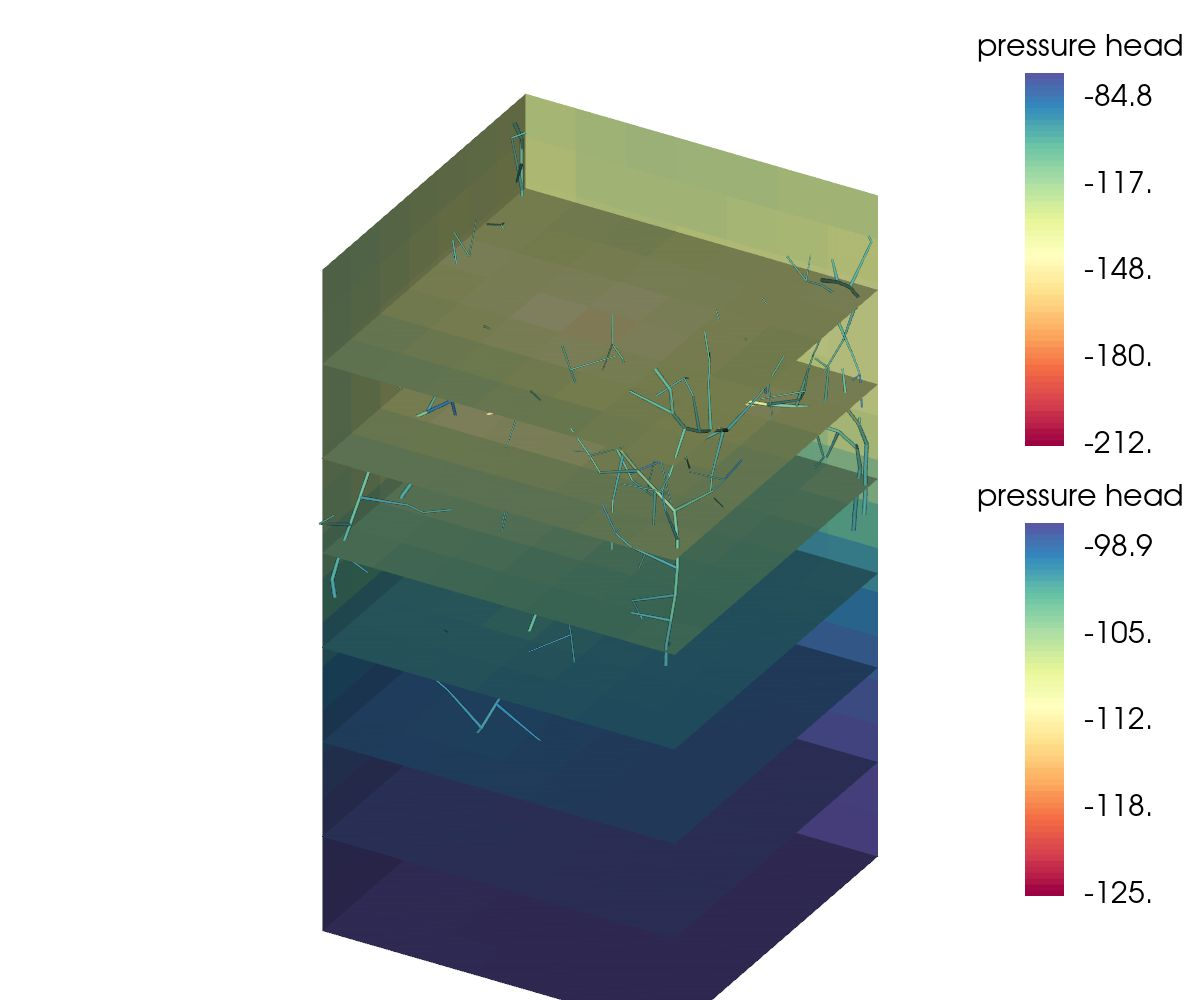

Cumulative soil uptake 3.191950660837129 [cm^3]


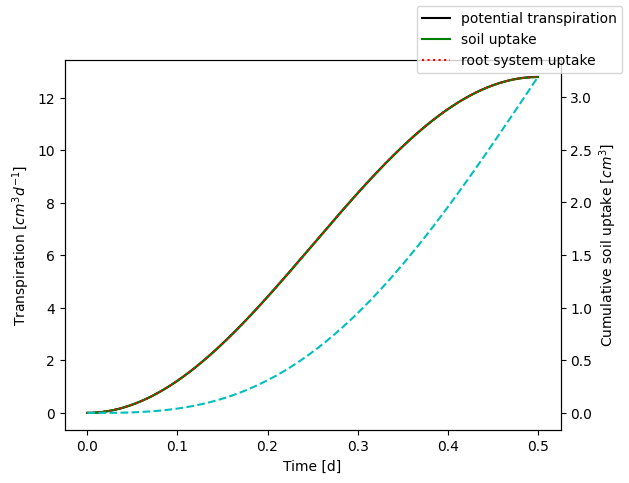

In [39]:

""" plots and output """
print ("Coupled benchmark solved in ", timeit.default_timer() - start_time, " s")
vp.plot_roots_and_soil(rs.ms, "pressure head", hsx, s, periodic, min_b, max_b, cell_number, interactiveImage = False)  # VTK vizualisation

plot_transpiration(out_times, water_uptake, collar_flux, lambda t: trans * sinusoidal(t))  # in rhizo_models.py

